# This file takes downloaded argo float data featuring oxygen measurements in the northern Humboldt Current system, grids them and produces a monthly picture of the horizontal oxygen distribution
author: Eike Koehn 

date: Nov 6, 2018

The oxygen data seems not to be quality checked, thus care is required when really analysing the data field.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import glob
import scipy as sp
import pandas as pd

In [2]:
path = '/home/koehne/Documents/PhD_projects/HUMPAC15_Model_evaluation/Argo_data/DataSelection_20181101_134039_6720635/'
filelist = glob.glob(path+'argo-profiles-*.nc')
# these profiles are all profiles available on the website http://www.coriolis.eu.org/Data-Products/Data-Delivery/Data-selection
# from Jan 1, 2000 to Nov, 2 2018 off the Peruvian coast

## Find all profiles with O2 sensors
float_with_O2 = []
for i in range(len(filelist)):
    fid = xr.open_dataset(filelist[i])
    if 'DOXY' in fid.data_vars:
        #print(fid.LATITUDE.max()>-20)
        #print(fid.LATITUDE.max())
        if fid.LATITUDE.max() > -20:
            float_with_O2.append(i)
    xr.Dataset.close(fid)

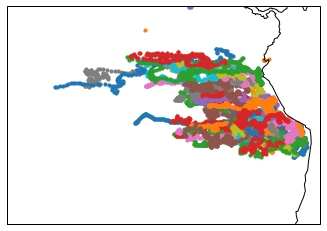

In [3]:
## PLOT LOCATIONS OF ALL EXISTING ARGO PROFILES with O2 data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# open dataset
for i in range(len(float_with_O2)):
    fid = xr.open_dataset(filelist[float_with_O2[i]])
    ax.scatter(fid.LONGITUDE,fid.LATITUDE,10,marker='o')
    xr.Dataset.close(fid)
ax.set_extent([-140, -68, -40, 10], crs=ccrs.PlateCarree())
plt.show()

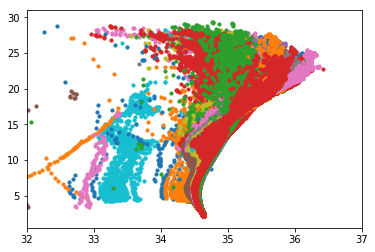

In [4]:
## MAKE A TS DIAGRAM
fig, ax = plt.subplots()
for i in range(len(float_with_O2)):
    fid = xr.open_dataset(filelist[float_with_O2[i]])
    if 'PSAL_ADJUSTED' in fid.data_vars :
        ax.scatter(fid.PSAL_ADJUSTED,fid.TEMP_ADJUSTED,10,marker='o')
    xr.Dataset.close(fid)
    ax.set_xlim([32,37])
plt.show()

# The resulting TS Diagram shows that some of the salinity data is off by quite a bit...?

In [25]:
for i in range(len(float_with_O2)):
    fid = xr.open_dataset(filelist[float_with_O2[i]])
    print(fid.PLATFORM_NUMBER.values[0],fid.PI_NAME.values[0])

b'3900521 ' b'Osvaldo ULLOA                                                   '
b'3900522 ' b'Osvaldo ULLOA                                                   '
b'3900523 ' b'Osvaldo ULLOA                                                   '
b'3900524 ' b'Osvaldo ULLOA                                                   '
b'3900531 ' b'Gerard ELDIN                                                    '
b'3900532 ' b'Gerard ELDIN                                                    '
b'3900533 ' b'Gerard ELDIN                                                    '
b'3900534 ' b'Gerard ELDIN                                                    '
b'3900713 ' b'ROBERT WELLER                                                   '
b'3900715 ' b'ROBERT WELLER                                                   '
b'3900716 ' b'ROBERT WELLER                                                   '
b'3900717 ' b'ROBERT WELLER                                                   '
b'3900718 ' b'ROBERT WELLER             

In [26]:
#Published Datasets of Argo floats 6900527,6900529,6900530,6900532 (Czeschel et al. 2018)
#https://doi.pangaea.de/10.1594/PANGAEA.892463

In [5]:
# grid all the oxygen data onto the same vertical pressure grid but store the profiles in a dictionary with keys as floatnames
presvec = np.linspace(0,1000,100)
oxydict = {}
latdict = {}
londict = {}
timedict = {}
for i in range(len(float_with_O2)):
    fid = xr.open_dataset(filelist[float_with_O2[i]])
    oxygrid = np.empty((0,np.size(presvec)))
    x = []
    lat = np.empty(0)
    lon = np.empty(0)
    time = []
    for j in fid.N_PROF:
        profilepresidx = np.isfinite(fid.PRES_ADJUSTED[j,]) 
        if any(fid.DOXY_ADJUSTED[j,:]>270.) or all(fid.DOXY_ADJUSTED[j,:]<10.):
            #print('Yes there is')
            fid.DOXY_ADJUSTED[j,:] = np.NaN
        profiledoxyidx = np.isfinite(fid.DOXY_ADJUSTED[j,:])
        profileidx = profilepresidx * profiledoxyidx
        if profileidx.sum() > 1:
            # interpolate oxygen data  
            interpdata = sp.interpolate.griddata(fid.PRES_ADJUSTED[j,profileidx],fid.DOXY_ADJUSTED[j,profileidx],presvec,method='linear')
            oxygrid = np.vstack((oxygrid,interpdata))
            # acquire corresponding lat/lon/time information
            lat = np.hstack((lat,fid.LATITUDE[j]))
            lon = np.hstack((lon,fid.LONGITUDE[j]))
            time.append(fid.JULD[j].values)
    oxydict[str(fid.PLATFORM_NUMBER[0].values)] = oxygrid
    londict[str(fid.PLATFORM_NUMBER[0].values)] = lon
    latdict[str(fid.PLATFORM_NUMBER[0].values)] = lat
    timedict[str(fid.PLATFORM_NUMBER[0].values)] = time
    if i%10 == 0:
        print(str(i)+' of '+str(len(float_with_O2)))
    xr.Dataset.close(fid)
plt.show()


0 of 54
10 of 54
20 of 54
30 of 54
40 of 54
50 of 54


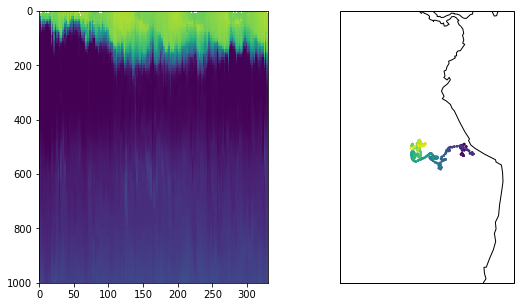

In [58]:
# example profiles of one float
profnum = np.arange(oxygrid.shape[0])
X,Y = np.meshgrid(profnum,presvec)
fig = plt.figure(figsize=(9,5))
ax = plt.subplot(1,2,1)
ax.pcolormesh(X,Y,oxygrid.T)
ax.invert_yaxis()

ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax2.coastlines()
ax2.scatter(fid.LONGITUDE,fid.LATITUDE,10,range(len(fid.LONGITUDE)),marker='.')
ax2.set_extent([-100, -68, -40, 10], crs=ccrs.PlateCarree())
plt.show()

In [7]:
## MERGE ALL DICTIONARIES TOGETHER INTO ONE BIG ARRAY (FOR O2, LON, LAT AND TIME, EACH)
oxygridlarge = np.empty((len(presvec),0))
lonlarge = np.empty(0)
latlarge = np.empty(0)
timelarge = []

for key in oxydict:
    if np.shape(oxydict[key].T.shape)[0]>1:
        oxygridlarge = np.hstack((oxygridlarge,oxydict[key].T))
        lonlarge = np.hstack((lonlarge,londict[key]))
        latlarge = np.hstack((latlarge,latdict[key]))
        #timelarge = np.hstack((timelarge,np.array(timedict[eval('"'+key+'"')])))
        #print(timedict[key][:])
        timelarge.extend(timedict[key])


print(np.shape(oxygridlarge))
print(np.shape(lonlarge))
print(np.shape(latlarge))
print(np.shape(timelarge))

(100, 5583)
(5583,)
(5583,)
(5583,)


5583


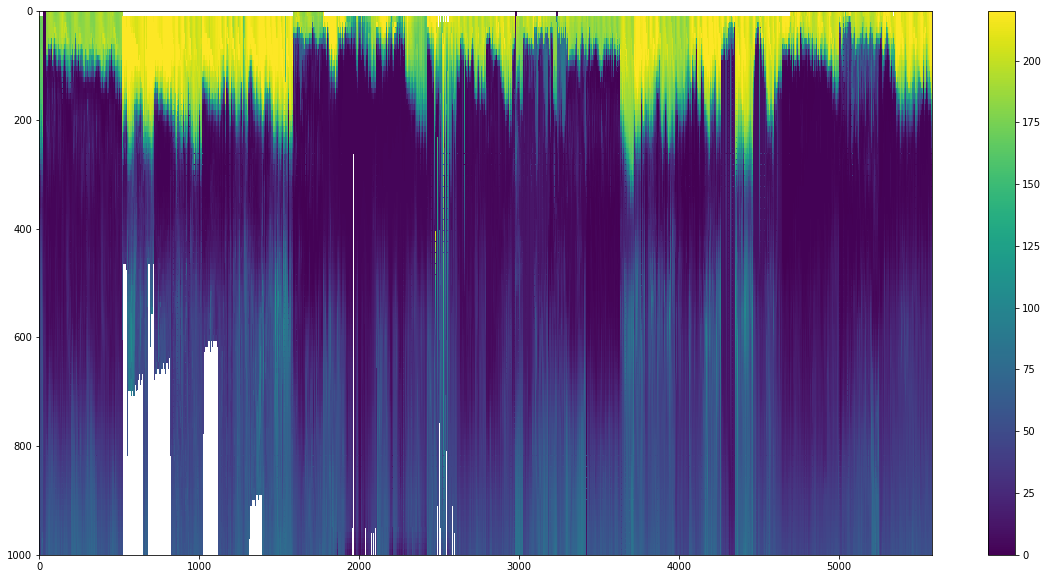

In [8]:
## PLOT ALL PROFILES TOGETHER

profnum = oxygridlarge.shape[1]
print(profnum)
X,Y = np.meshgrid(np.arange(profnum),presvec)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
plt.pcolormesh(X,Y,oxygridlarge,vmin=0, vmax=220)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [9]:
# create horizontal grid to interpolate data onto
lonmin, lonmax = -140., -68.
latmin, latmax = -40., 10.
gridsize = 1.
lonvec = np.arange(lonmin,lonmax,gridsize)
latvec = np.arange(latmin,latmax,gridsize)
X,Y = np.meshgrid(lonvec,latvec)
Xup = X + gridsize/2.
Xlo = X - gridsize/2.
Yup = Y + gridsize/2.
Ylo = Y - gridsize/2.

In [10]:
# count number of profiles per bin
countmat = np.zeros_like(X) + np.NaN
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        countmat[i,j] = np.sum((lonlarge >= Xlo[i,j])*(lonlarge < Xup[i,j])*(latlarge>=Ylo[i,j])*(latlarge < Yup[i,j]))

# set up index matrix to assign profiles indices to each grid cell. this matrix also features a temporal dimension with 12 slices (climatology like)
profilenummat = np.zeros((12,X.shape[0],X.shape[1],int(np.nanmax(countmat))))+ np.NaN
# set up matrix to contain gridded profiles. this matrix also features a temporal dimension with 12 slices (climatology like)
argogridded = np.zeros((12,X.shape[0],X.shape[1],int(np.size(presvec))))+ np.NaN
for k in range(12):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):      
            states = (lonlarge >= Xlo[i,j])*(lonlarge < Xup[i,j])*(latlarge>=Ylo[i,j])*(latlarge < Yup[i,j])*(pd.to_datetime(timelarge).month==k+1)
            statesidx = np.where(states)[0]
            #print(statesidx)
            profilenummat[k,i,j,:len(statesidx)] = statesidx
            if len(statesidx)>0:
                #print(np.nanmean(oxygridlarge[:,statesidx],axis=1))
                argogridded[k,i,j,:] = np.nanmean(oxygridlarge[:,statesidx],axis=1)
    print(k)

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

0


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

1


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

2


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

3


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

4


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

5


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

6


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

7


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

8


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

9


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

10


/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_laun

11


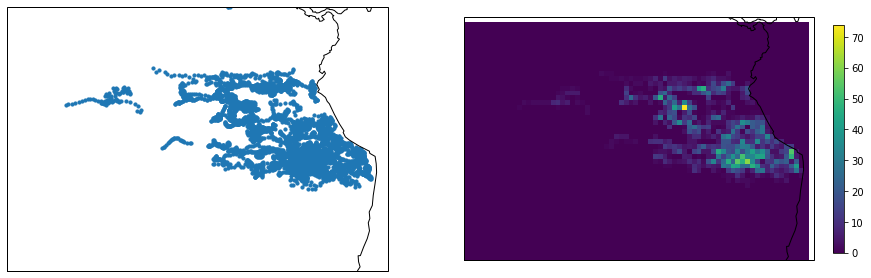

In [19]:
# plot the float trajectories with ok O2 sensor
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(lonlarge,latlarge,10,marker='o')
ax.set_extent([-140, -68, -40, 10], crs=ccrs.PlateCarree())

#plot grid with number of profiles per grid cell
ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax2.coastlines()
h0 = ax2.pcolor(X,Y,countmat)
ax2.set_extent([-140, -68, -40, 10], crs=ccrs.PlateCarree())
plt.colorbar(h0,fraction=0.03)
plt.show()

/home/koehne/.conda/envs/eikes_miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


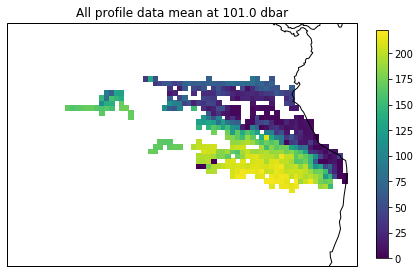

In [28]:
#plot gridded data
fig = plt.figure(figsize=(15,8))
ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax2.coastlines()
h0 = ax2.pcolor(X,Y,np.nanmean(argogridded[:,:,:,10],axis=0))
ax2.set_extent([-140, -68, -40, 10], crs=ccrs.PlateCarree())
plt.colorbar(h0,fraction=0.03)
plt.title('All profile data mean at '+str(round(presvec[10]))+' dbar')
plt.show()

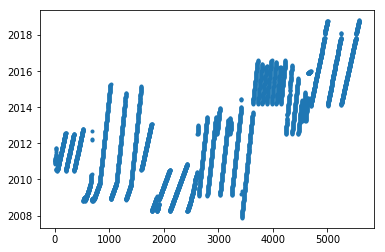

In [13]:
# temporal distribution of the measurements
plt.subplots()
plt.plot(timelarge,'.')
plt.show()

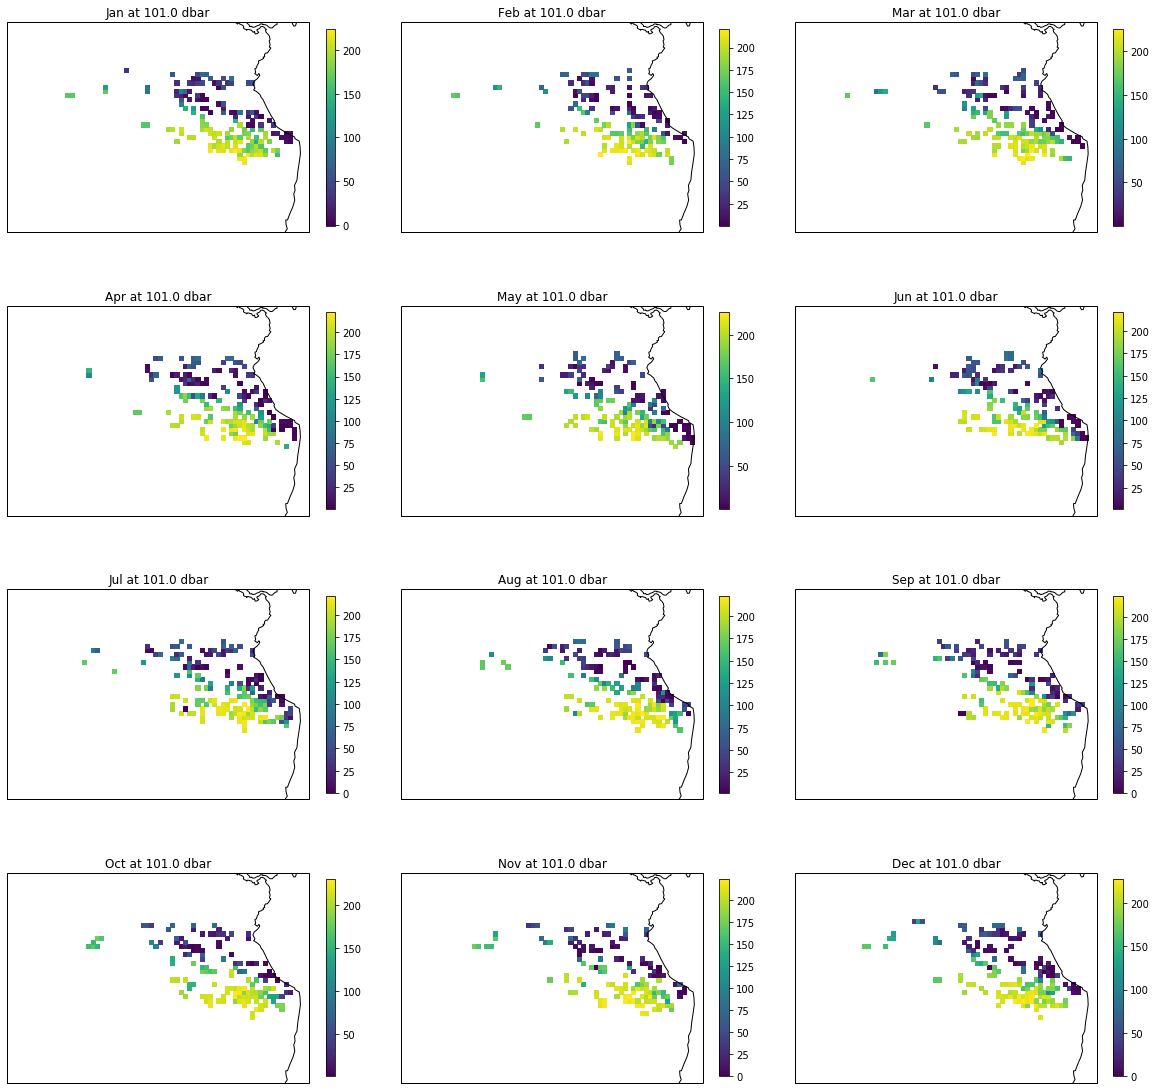

In [21]:
#plot gridded monthly data
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',]
fig = plt.figure(figsize=(20,20))
for i in range(12):
    ax = plt.subplot(4,3,i+1,projection=ccrs.PlateCarree())
    ax.coastlines()
    h0 = ax.pcolor(X,Y,argogridded[i,:,:,10])
    ax.set_extent([-140, -68, -40, 10], crs=ccrs.PlateCarree())
    plt.colorbar(h0,fraction=0.03)
    plt.title(months[i]+' at '+str(round(presvec[10]))+' dbar')
